#### Implementation of the following research paper on a real world data.
[research paper](https://www.comp.nus.edu.sg/~leews/publications/acl17.pdf)

#### importing packages and dataset
#####  Data has been scrapped from a leading ecommerse website in India. Scrapped all the customer reviews about smart phones belonging to different companies. Total data points are about 350k which consists of rating(int), reviews(text) and title(text).

In [ ]:
# Mounting files on google drive which will ease file accessing 
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
import pandas as pd 

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/REVIEWS/reviews.pickle")  

In [ ]:
# Launching tensorflow 2 and invoking GPU if available on Google Collab
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# importing necessary modules

import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Input,Dot,Reshape,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [ ]:
df["review"]=df["review"].apply(lambda x:x.strip("READ MORE").lower())

In [ ]:
df.head()   

,rating,review,title
0,5,good,Best in the market!
1,5,flashlight is very very bad,Worst experience ever!
2,4,battery is too bad .,Absolute rubbish!
3,5,bateri not warking,Utterly Disappointed
4,5,very bad 😠,Very poor


#### Text Preprocessing

In [ ]:
#  removing some of the common contractions.
def decontractions(phrase):

    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [ ]:
# Installing a module to work with emojis. This module provides text format to emojis. 
# Although this will help in converting emojis to text, I only removed the emojis by replacing them with empty character. Did not use their text format. 
!pip install emot

     |████████████████████████████████| 61 kB 19 kB/s 


In [ ]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS # contains english text of emojis and emoticons in dict format 
def convert_emojis(review):
  for x in review:
    if x in UNICODE_EMO.keys():
      review=review.replace(x,"")
  return review

In [ ]:
#Converting all the extra spaces into single space. This will help while splitting the data in the future.
def removecharacters(review):
  review= re.sub('[^A-Za-z0-9]+',' ',review)  #anything exept numbers and alphabets, replace them with space
  review=re.sub(r"\n"," ",review)  #new lines into space
  review=re.sub(r"\t"," ",review)  #tabs into space
  review=re.sub(r"\v"," ",review)  #vertical tab into space
  review=re.sub(r"\s"," ",review)   #all extra spaces into single space
  return review.lower()

In [ ]:
df["review"]=df["review"].apply(convert_emojis)
df["review"]=df["review"].apply(decontractions)
df["review"]=df["review"].apply(removecharacters)

In [ ]:
# Using NLTK for PoS tagging and Stopwords removal
# Downloading the corresponding packages

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [ ]:
# Using all the nouns in the reviews only (Ressults are better when considering all the words. So did not implement this)
def onlynouns(review):
  lis= " ".join([each.strip(" ") for each,pos in nltk.pos_tag(review.split()) if (pos=="NN" )])
  return lis
df["review"]=df["review"].apply(lambda x:onlynouns(x))

In [ ]:
#some custom stopwords and also stopwords from NLTK
stopword= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","not","np","should","iam"]).union(stop_words)
def removestopwords(review):
  return " ".join([word for word in review.split(" ") if not word in stopword])
df["review"]=pd.DataFrame(df["review"].apply(lambda x:removestopwords(x)))

In [ ]:
df["len"]=df.review.str.split().apply(len)  #number of words in the review

df=df.loc[(df["len"]>0) & (df["len"]<225)]  # considering only reviews with number of words less than 225 (this constributes more than 99.5 percentile)

In [ ]:
tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') #tensorflow tokenising
tkn.fit_on_texts(df['review'].values)
word_countdict=tkn.word_counts  #word count dictionary

In [ ]:
def word_count(review):
  return  " ".join([word for word in review.split() if word_countdict[word]>10] ) #considering all the words that appeared more than 10 times in the entire carpora
df["review"]=pd.DataFrame(df["review"].apply(lambda x:word_count(x)))

In [ ]:
df["len"]=df.review.str.split(" ").apply(len)

df=df.loc[(df["len"]>0)]     #removing empty reviews

In [ ]:
tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')  #tokenising again
tkn.fit_on_texts(df['review'].values)
word_countdict=tkn.word_counts

In [ ]:
import pickle   #dumping data frame as a pickel file
with open("/content/drive/My Drive/REVIEWS/df_nouns.p","wb") as f:
  pickle.dump(df,f)                              

In [ ]:
import pickle
with open("/content/drive/My Drive/REVIEWS/df_nouns.p","rb") as f:
  df=pickle.load(f)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#df=df.loc[df["review"].apply(lambda x:len(x.strip().split())>0)].reset_index(drop=True)

In [ ]:
#tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
#tkn.fit_on_texts(df['review'].values)
#word_countdict=tkn.word_counts

In [ ]:
seq_texts=tkn.texts_to_sequences(df['review'].values)  #converting tokenised reviews into sequence of integers with each integer corresponding to one word in the corpus

In [ ]:
text=pd.Series(df['review'].values).apply(lambda x: x.split())  #spliting the reviews in a format suitable to  feed into Fasttext for trainig vocab 

In [ ]:
word_countdict["delivery"]

13231

In [ ]:
text

0                                                    [good]
1                                         [flashlight, bad]
2                                            [battery, bad]
3                                                 [warking]
4                                                     [bad]
                                ...                        
362991    [best, budget, smart, phone, especially, cameras]
362992                         [good, phone, normal, users]
362993    [xcellent, product, price, 6k, worth, every, p...
362994    [nyc, products, basic, user, good, mobile, wor...
362995                                    [good, honor, 9s]
Length: 362996, dtype: object

#### Learning word embeddings 
##### FastText is a library for learning word embeddings. FastText is bult by Facebook Ai team. One of the key features of fastText word representation is its ability to produce vectors for any words, even made-up ones. Indeed, fastText word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words. This is one of the main adavantages over word2vec. Since our data is a real world data with lot of misspelt words and words out of english vocabulary, I have chosen Fasttext. 

In [ ]:
#FastText is also available in Gensim.
from gensim.models import FastText 

In [ ]:
#  We are training the model on our own vocabulary(text data) rather than using pretrained wordembeddings 
# skipgram based training. Considers all the words that appeared atleast once. Window size is ten.
model = FastText(size=100, negative=5, min_count=1,window=10,iter=250,sg=1) 
model.build_vocab(text) 

In [ ]:

gensim_fasttext = model.train(sentences=text, 
                           sg=1, ##skipgram
                           epochs=250, ##no of iterations
                           size=100, ##dimentions of word embedding
                           seed=1,
                           total_examples=model.corpus_count)

In [ ]:
model.save("/content/drive/My Drive/REVIEWS/wordembeddings_nouns") #saving the trainedmodel into drive

In [ ]:
from gensim.models import FastText
model=FastText.load("/content/drive/My Drive/REVIEWS/wordembeddings_nouns") #reusing already trained model

In [ ]:
model.wv.similar_by_word("battery") # you can observe how similar are the misspelt words with the actual correctly spelt word.

[('bettery', 0.7582681179046631),
 ('batter', 0.7468189001083374),
 ('performance', 0.7118053436279297),
 ('battry', 0.6854369640350342),
 ('battary', 0.6752023696899414),
 ('backup', 0.663201630115509),
 ('camera', 0.6577006578445435),
 ('display', 0.638664722442627),
 ('average', 0.6315059065818787),
 ('charging', 0.6301984190940857)]

In [ ]:
max(df.len)

223

In [ ]:
#padding the sequences to max length review. used post padding. 
#Batch training text sequences of variable length is not possible. So padding is required  
seq_texts=tf.keras.preprocessing.sequence.pad_sequences(seq_texts,
                                                         maxlen=max(df.len),
                                                         padding='post')

In [ ]:
import pickle
with open("/content/drive/My Drive/REVIEWS/seq_texts_nouns.p","wb") as f:
  pickle.dump(seq_texts,f)

In [ ]:
import pickle
with open("/content/drive/My Drive/REVIEWS/seq_texts_nouns.p","rb") as f:
  seq_texts=pickle.load(f)

In [ ]:
seq_texts

array([[   1,    0,    0, ...,    0,    0,    0],
       [2399,   26,    0, ...,    0,    0,    0],
       [   7,   26,    0, ...,    0,    0,    0],
       ...,
       [  60,    5,    9, ...,    0,    0,    0],
       [ 236,  139,  589, ...,    0,    0,    0],
       [   1,  559, 6995, ...,    0,    0,    0]], dtype=int32)

In [ ]:
len(model.wv.vocab) #total vocab 

6995

#### Variables that go into the model

In [ ]:
embed_inputdim=len(model.wv.vocab)
embed_outputdim=100
trained_weights=np.vstack((np.zeros((1,100)),model.wv.vectors)) #used for initialising the embedding layer
aspects_k=10 #number of aspects
dense=100
inputlength=max(df.len) 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=aspects_k,random_state=0,max_iter=500,n_jobs=-1).fit(trained_weights) #clustering the trained wordembeddings into 10 clusters
init=tf.constant_initializer(kmeans.cluster_centers_) #used for initialing the weights of final dense layer
init

#### Building custom attention layer

In [ ]:
#custom build attention layer

class Attention(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()
      
      self.soft = tf.keras.layers.Softmax(axis=-2,name="softmax_att") #softmax layer
      self.dot=tf.keras.layers.Dot(axes=(-1,-1),name="dot_att")       #dot layer
      self.w = tf.Variable(
            initial_value=tf.random_normal_initializer()(shape=(100, 100), dtype="float32"),
            trainable=True,
        )              #weights that captures essense between the word embedding and global context vector(or average of all the word embedding of the sentence)
  
    def call(self,embed_output, mask=None):

      ys = tf.reduce_mean(embed_output,axis=-2) #average of all word embeddings of the sentence
      ys=tf.expand_dims(ys,axis=-2)
      eW=tf.matmul(embed_output, self.w)
      eW = eW * tf.expand_dims(tf.cast(mask,tf.float32),-1) #maskpropagation. Preventing masked elements into calculations
      f=self.dot([eW, ys])
      f = f+tf.expand_dims(tf.cast(tf.math.equal(mask, False), f.dtype)*-1e9,-1) #multiplying all the masked elements by -1e9 so that the softmax step do not impact the vectors
      f=self.soft(f)
      zs=tf.math.reduce_sum(f*embed_output,axis=-2) #zs is aspect embedding space after attention mechanisms on words of the sentence
                                                    # f - softmax - gives info about unimportant words in the sentence for extracting aspects 
      
      return zs,f

#### Building custom model which outputs loss on calling it

In [ ]:
# custom model

class model_(tf.keras.Model):
  def __init__(self,embed_inputdim,embed_outputdim,trained_weights,aspects_k,dense,inputlength):
    super().__init__()
    self.embed_inputdim=embed_inputdim
    self.inputlength=inputlength
    self.embed_outputdim=embed_outputdim
    self.trained_weights=trained_weights
    self.embedding=Embedding(input_dim=self.embed_inputdim+1,output_dim=self.embed_outputdim,mask_zero=True,
                             input_length=self.inputlength,weights=[self.trained_weights],name="embedding_layer",trainable=True) #embedding layer. Zero masking
    self.attention=Attention()
    self.aspects_k=aspects_k #number of aspects
    self.k = tf.keras.layers.Dense(aspects_k,name="dim_reduction_layer",activation="softmax")
    self.dense=dense 
    self.final=tf.keras.layers.Dense(self.dense,name="final_dense",kernel_initializer=init) #weights are initialised with embedding clusters
  def call(self,input):
    e=self.embedding(input[0])
    mask = self.embedding.compute_mask(input[0]) #computing mask so that this this can be used while propagating mask for subsequent layers
    zs=self.attention(e, mask = mask)[0] #aspect vector
    pt=self.k(zs)  #dimensionality vector
    rs=self.final(pt) #reconstructed vector

    # building regulariser to be used in the loss. [(T*transpose(T))-I]
    reg=tf.tensordot(tf.linalg.normalize(self.final.weights[0],axis=1)[1],tf.linalg.normalize(self.final.weights[0],axis=1)[1],axes=[[1],[1]])
    reg=reg-tf.ones([self.aspects_k,self.aspects_k])
    reg=tf.norm(reg, ord='euclidean', axis=None, keepdims=None, name=None)
    # calculating loss
    r=tf.expand_dims(rs,-2)
    f=tf.tensordot(rs,zs,[[0,1],[0,1]])
    a=self.embedding(input[1])
    a=tf.reduce_mean(a,axis=-2)
    loss=tf.reduce_sum(tf.nn.relu(1-tf.reduce_sum(tf.tensordot(a,r,[[0,2],[0,2]]))+f))+1*reg #this is the loss which is to be minimised
    return loss,pt,rs 
    


#### Building tensorflow dataset from generators

In [ ]:
#data generating
from random import seed
from random import randint

def gendata():
  seed(42)
  for i in range(0,len(seq_texts)):
    lis=[]
    lent=[]
    while len(lent)<20:
      value = randint(0, len(seq_texts)-1)
      if value==i:
        continue
      lis.append(seq_texts[value])
      lent.append(value)

    yield seq_texts[i],lis
datagen=tf.data.Dataset.from_generator(gendata, output_types=(tf.int32,tf.int32))
datagen=datagen.repeat(1).shuffle(buffer_size=1024).batch(100).prefetch(tf.data.experimental.AUTOTUNE)

#### Model training

In [ ]:
#model initialisation
abae=model_(embed_inputdim,embed_outputdim,trained_weights,aspects_k,dense,inputlength)
# optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(input):
    with tf.GradientTape() as tape:
        #forward propagation
        loss = abae(input)[0]
        #print(loss)

    #getting gradients
    gradients = tape.gradient(loss, abae.trainable_variables)
    #applying gradients
    optimizer.apply_gradients(zip(gradients, abae.trainable_variables))

    return loss, gradients

train_loss = tf.keras.metrics.Mean(name='train_loss')


##check point to save
checkpoint_path = "/content/drive/My Drive/abae_logs/checkpoints/abae/train"
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=abae)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)


it=0
loss_list=[]
for k in range(0,15): # k - number of iterations
  counter = 0

  # navigating through each batch
  for input in datagen:

      loss_, gradients = train_step(input)
      #adding loss to train loss
      train_loss(loss_)
      counter = counter + 1
      template = '''Done {} step, Loss: {:0.6f}'''

    
      if counter%100==0:
              # printing loss after every 100th batch in an epoch
        print(template.format(counter, train_loss.result()))
        
  loss_list.append(train_loss.result()) #appending loss after every epoch
  ckpt_save_path  = ckpt_manager.save() #checkpointing after every epoch
  print ('Saving checkpoint for iteration {} at {}'.format(k+1, ckpt_save_path))
  print(counter, train_loss.result())
  train_loss.reset_states()             #resetting loss after every epoch
  
  


Done 100 step, Loss: 28.968550
Done 200 step, Loss: 20.588682
Done 300 step, Loss: 15.580440
Done 400 step, Loss: 12.309283
Done 500 step, Loss: 9.942160
Done 600 step, Loss: 8.286394
Done 700 step, Loss: 7.103624
Done 800 step, Loss: 6.216487
Done 900 step, Loss: 5.526466
Done 1000 step, Loss: 4.974433
Done 1100 step, Loss: 4.522669
Done 1200 step, Loss: 4.146284
Done 1300 step, Loss: 3.827788
Done 1400 step, Loss: 3.554776
Done 1500 step, Loss: 3.318174
Done 1600 step, Loss: 3.111142
Done 1700 step, Loss: 2.928475
Done 1800 step, Loss: 2.766082
Done 1900 step, Loss: 2.620814
Done 2000 step, Loss: 2.490072
Done 2100 step, Loss: 2.371783
Done 2200 step, Loss: 2.264296
Done 2300 step, Loss: 2.166110
Done 2400 step, Loss: 2.076089
Done 2500 step, Loss: 1.993250
Done 2600 step, Loss: 1.916873
Done 2700 step, Loss: 1.846112
Done 2800 step, Loss: 1.780400
Done 2900 step, Loss: 1.719220
Done 3000 step, Loss: 1.662116
Done 3100 step, Loss: 1.608696
Done 3200 step, Loss: 1.558633
Done 3300 ste

#### Loss - plot

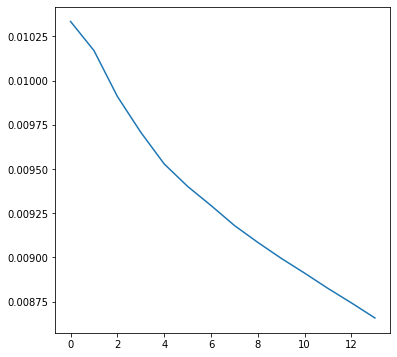

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(loss_list[1:])
plt.show()

In [ ]:
abae.summary()

Model: "model__1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  multiple                  699600    
_________________________________________________________________
attention_1 (Attention)      multiple                  10000     
_________________________________________________________________
dim_reduction_layer (Dense)  multiple                  1010      
_________________________________________________________________
final_dense (Dense)          multiple                  1100      
Total params: 711,710
Trainable params: 711,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in abae.weights:
  print(i.name, i.shape)

model__1/embedding_layer/embeddings:0 (6996, 100)
Variable:0 (100, 100)
model__1/dim_reduction_layer/kernel:0 (100, 10)
model__1/dim_reduction_layer/bias:0 (10,)
model__1/final_dense/kernel:0 (10, 100)
model__1/final_dense/bias:0 (100,)


In [ ]:
topics=abae.weights[4].numpy()
topic_words={}
k=1
for i in range(len(topics)):
  topic_words["topic_"+str(k)]=np.argsort(model.wv.cosine_similarities(topics[i],model.wv.vectors))[::-1][0:20]
  k=k+1
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

#### Aspects

In [ ]:
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,rs,amoled,deliver,awesome,feels,achha,turn,stunning,nice,fraud
1,billion,stunning,shipping,really,classy,koi,notifications,disappoint,good,seller
2,discount,amazing,ekart,phone,grip,mast,app,great,nicr,refused
3,offer,cameras,30th,good,sleek,hai,disable,awesome,awesome,fault
4,3500,awesome,ordered,superb,premium,ko,access,really,wesome,sent
5,discounts,brilliant,delivered,also,design,acha,application,amazing,greate,executives
6,13500,outstanding,delivery,one,looks,nhi,vibrate,indeed,thanku,accepting
7,3k,ai,flipkart,great,handy,kharab,irritates,beast,avarge,accept
8,13000,decent,saturday,excellent,hold,ek,bluetooth,loving,mast,replacement
9,8999,really,oct,battery,slippery,ki,button,outstanding,fantastic,flipkart


In [ ]:
df.shape

(362996, 4)

In [ ]:
actual=pd.read_pickle("/content/drive/My Drive/REVIEWS/reviews.pickle")
actual.shape

(363572, 3)

In [ ]:
abae.weights[0]

<tf.Variable 'model_/embedding_layer/embeddings:0' shape=(6996, 100) dtype=float32, numpy=
array([[ 0.01037038, -0.01036337, -0.01036488, ..., -0.01038307,
        -0.01031592,  0.01036366],
       [-0.12056135,  0.02119086, -0.3640991 , ...,  0.06567799,
         0.12151092,  0.2287009 ],
       [ 0.02999476, -0.09732407, -0.22800502, ..., -0.02116774,
        -0.02559429,  0.17921406],
       ...,
       [-0.16476521, -0.31051284,  1.4704353 , ..., -0.34270912,
        -0.9164348 ,  0.37284312],
       [-0.1407243 , -0.76751727, -0.35094082, ..., -0.07251757,
        -0.336739  , -0.24188508],
       [-0.17931011,  0.65131986,  0.03546059, ...,  0.03621732,
        -0.5659493 , -0.00681651]], dtype=float32)>

### Restoring the training of a model from the latest checkpoint

In [ ]:
for i in datagen.take(1):
  k=i
test=model_(embed_inputdim,embed_outputdim,trained_weights,aspects_k,dense,inputlength)
test(i)

(<tf.Tensor: shape=(), dtype=float32, numpy=119.447205>,
 <tf.Tensor: shape=(100, 10), dtype=float32, numpy=
 array([[0.09102347, 0.09757339, 0.06039898, 0.08577572, 0.09481385,
         0.11303271, 0.11888027, 0.1785904 , 0.07754516, 0.08236608],
        [0.09461122, 0.10913482, 0.06149137, 0.08088474, 0.1029571 ,
         0.09070311, 0.1022353 , 0.14011365, 0.11621718, 0.10165148],
        [0.11325913, 0.13134882, 0.079891  , 0.07514646, 0.106176  ,
         0.08472864, 0.10298117, 0.10068797, 0.12339724, 0.08238351],
        [0.10802439, 0.10670919, 0.09470153, 0.0605552 , 0.11308976,
         0.10538805, 0.07689005, 0.0986105 , 0.12019341, 0.11583799],
        [0.11133365, 0.13383405, 0.06969249, 0.08906975, 0.08463766,
         0.10438267, 0.10766024, 0.09024678, 0.11245451, 0.09668816],
        [0.08561025, 0.11955554, 0.06765518, 0.07148482, 0.12827294,
         0.0780909 , 0.10072514, 0.13991824, 0.11747786, 0.09120909],
        [0.10363661, 0.10567259, 0.05974306, 0.07917746, 

In [ ]:
#model initialisation
#abae=model_(embed_inputdim,embed_outputdim,trained_weights,aspects_k,dense,inputlength)
# optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(input):
    with tf.GradientTape() as tape:
        #forward propagation
        loss = test(input)[0]
        #print(loss)

    #getting gradients
    gradients = tape.gradient(loss, test.trainable_variables)
    #applying gradients
    optimizer.apply_gradients(zip(gradients, test.trainable_variables))

    return loss, gradients
#no_iterations=1147*5          #epochs
train_loss = tf.keras.metrics.Mean(name='train_loss')


checkpoint_path = "/content/drive/My Drive/abae_logs/checkpoints/abae/train"
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=test)

latest = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(latest)


##check point to save
#checkpoint_path = "/content/drive/My Drive/abae_logs/checkpoints/abae/train_v2"
#ckpt = tf.train.Checkpoint(optimizer=optimizer, model=test)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)


it=0
loss_list=[]
for k in range(0,1):
  counter = 0
  for input in datagen:

      loss_, gradients = train_step(input)
      #adding loss to train loss
      train_loss(loss_)
      counter = counter + 1
      template = '''Done {} step, Loss: {:0.6f}'''

    
      if counter%100==0:
        print(template.format(counter, train_loss.result()))
        
  loss_list.append(train_loss.result())
  ckpt_save_path  = ckpt_manager.save()
  print ('Saving checkpoint for iteration {} at {}'.format(k+1, ckpt_save_path))
  print(counter, train_loss.result())
  train_loss.reset_states()
  
  


Done 100 step, Loss: 0.008561
Done 200 step, Loss: 0.008550
Done 300 step, Loss: 0.008563
Done 400 step, Loss: 0.008538
Done 500 step, Loss: 0.008546
Done 600 step, Loss: 0.008532
Done 700 step, Loss: 0.008539
Done 800 step, Loss: 0.008539
Done 900 step, Loss: 0.008542
Done 1000 step, Loss: 0.008534
Done 1100 step, Loss: 0.008536
Done 1200 step, Loss: 0.008532
Done 1300 step, Loss: 0.008531
Done 1400 step, Loss: 0.008532
Done 1500 step, Loss: 0.008530
Done 1600 step, Loss: 0.008528
Done 1700 step, Loss: 0.008530
Done 1800 step, Loss: 0.008530
Done 1900 step, Loss: 0.008526
Done 2000 step, Loss: 0.008526
Done 2100 step, Loss: 0.008525
Done 2200 step, Loss: 0.008523
Done 2300 step, Loss: 0.008524
Done 2400 step, Loss: 0.008524
Done 2500 step, Loss: 0.008521
Done 2600 step, Loss: 0.008521
Done 2700 step, Loss: 0.008522
Done 2800 step, Loss: 0.008518
Done 2900 step, Loss: 0.008518
Done 3000 step, Loss: 0.008517
Done 3100 step, Loss: 0.008516
Done 3200 step, Loss: 0.008515
Done 3300 step, L

In [ ]:
topics=test.weights[4].numpy()
topic_words={}
k=1
for i in range(len(topics)):
  topic_words["Aspect_"+str(k)]=np.argsort(model.wv.cosine_similarities(topics[i],model.wv.vectors))[::-1][0:20]
  k=k+1
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

,Aspect_1,Aspect_2,Aspect_3,Aspect_4,Aspect_5,Aspect_6,Aspect_7,Aspect_8,Aspect_9,Aspect_10
0,rs,amoled,shipping,awesome,feels,achha,turn,disappoint,nice,fraud
1,billion,stunning,deliver,really,classy,koi,notifications,stunning,good,seller
2,discount,amazing,30th,good,grip,mast,access,great,nicr,refused
3,offer,cameras,ekart,phone,sleek,acha,app,awesome,awesome,fault
4,3500,awesome,ordered,superb,premium,kharab,disable,really,greate,executives
5,13000,brilliant,delivered,great,design,hai,vibrate,indeed,wesome,accepting
6,8999,outstanding,delivery,also,looks,ko,irritates,amazing,mast,sent
7,3k,decent,flipkart,excellent,handy,nhi,button,beast,avarge,accept
8,discounts,ai,saturday,one,hold,ek,application,loving,thanku,flipkart
9,13500,especially,august,amazing,hands,ki,icon,outstanding,fantastic,replacement


### Aspects Inference
#### From above collection of words, we can conclude some of the aspects as below ---
Aspect1 - Price

Aspect2 - Camera and the picture display

Aspect3 - Delivery

Aspect4 - Positive intent words

Aspect5 - Physical experience (or features) of mobile

Aspect6 - Collection of Hindi Language words 

Aspect7 - Accessing different applications

Aspect8 - Extreme positive intent about product

Aspect9 - Incorrectly spelled positive intent about product

Aspect10- Bad CustomerService experience